In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import statistics as stat
import random
import matplotlib.pyplot as plt
import re
import pysam
import scipy.stats as s
import math
import pickle

# from https://github.com/getzlab/cnv_suite
from cnv_suite import simulate
from cnv_suite import visualize

## Helpful methods for CNV_Profile and Phylogeny classes in cnv_suite

In [2]:
# add methods to simulate.CNV_Profile().phylogeny to set the phylogeny manually

def set_phylogeny(self, phylogeny_dict):
    self.num_subclones = phylogeny_dict['num_subclones']
    self.parents = phylogeny_dict['parents']
    self.ccfs = phylogeny_dict['ccfs']
    
def get_children(self, node):
    """Return children for the specified clone
        
    :param node: index of desired clone
    :return: (dict) representing the child clones and their respective CCFs"""

    cluster_list=[]
    for k, v in self.parents.items():
        if v==node:
            cluster_list.append(k)

    return cluster_list
    
simulate.cnv_profile.Phylogeny.set_phylogeny = set_phylogeny
simulate.cnv_profile.Phylogeny.get_children = get_children

In [3]:
# add methods to simulate.CNV_Profile().CNV_Profile to get and set the cnv events manually

def set_events_and_phylogeny(self, event_trees, phylogeny):
    self.event_trees = event_trees
    self.phylogeny =  phylogeny
    
def pickle_events(self, out_file_name):
    event_trees = self.event_trees
    
    # open a file, where you ant to store the data
    file = open(out_file_name, 'wb')
    pickle.dump(event_trees, file)
    file.close()
    
simulate.cnv_profile.CNV_Profile.pickle_events = pickle_events
simulate.cnv_profile.CNV_Profile.set_events_and_phylogeny = set_events_and_phylogeny

## Set output folder and reference data folder

In [4]:
output_folder = './output_data'
reference_folder = './reference_files'

## Populate reference data folder

In [5]:
# need to implement streaming directly from the cloud...for now just download target intervals, fasta, fasta index, and fasta dict locally

# target_interval_file = 'gs://getzlab-workflows-reference_files-oa/hg19/twist/broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list'
# fasta_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.fasta'
# fasta_index_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.fasta.fai'
# fasta_dict_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.dict'

target_interval_file = f'{reference_folder}/hg19_twist_broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list'
fasta_file_path = f'{reference_folder}/hg19_Homo_sapiens_assembly19.fasta'

## Set phylogeny for simulated patients

In [6]:
# generate phylogeny
patient_id = 'patient1'
sample_id_dict = {'t1': f'{patient_id}_t1', 't2': f'{patient_id}_t2', 't3': f'{patient_id}_t3'}

timepoints_dict = {'t1': 0, 't2': 100, 't3': 300}

clones_dict = {'num_subclones': 6,
                       'parents': {1: None, 2:1, 3:1, 4:2, 5:4, 6:4, 7:3}
                      }

# be careful when setting your own phylogeny that the ccfs are consistent:
# at all time points, the ccfs of a clone must be greater than or equal to the sum of the ccfs of its children

ccfs_dict = {'t1': {1:1.0, 2:0.9,  3:0.1,  4:0.8,  5:0.15,  6:0.1,  7:0.05},
             't2': {1:1,   2:0.95, 3:0.05, 4:0.9,  5:0.3,   6:0.05, 7:0.03},
             't3': {1:1,   2:0.3,  3:0.6,  4:0.1,  5:0.05,  6:0.03, 7:0.45}
            }
purity_dict = {'t1': 0.7, 't2': .45, 't3':.9}

timepoints=list(ccfs_dict.keys())

phylogeny_dict={}

for t in timepoints:
    phylogeny = simulate.CNV_Profile().phylogeny
    phy_dict = clones_dict
    phy_dict['ccfs'] = ccfs_dict[t]
    phylogeny.set_phylogeny(phy_dict)
    phylogeny_dict[t] = phylogeny

## Generate CNV profiles

In [7]:
# Generate copy number events, then store so they can be reloaded for each timepoint.
# Note: CNV_Profile.event_trees are specific to the phylogeny, so don't reuse them if you change that, just generate new ones

### generate ###

# patient1_cnv_profile = simulate.CNV_Profile()
# patient1_cnv_profile.phylogeny = p1_t1_phy
# patient1_cnv_profile.add_cnv_events(arm_num=20, focal_num=600, p_whole=0.6, ratio_clonal=0.5,
#                        median_focal_length=1.8 * 10**6)
# patient1_cnv_profile.pickle_events('p1_cnv_events_600_focal_20_arm.pkl')

################

##### load #####

file = open(f'{output_folder}/p1_cnv_events_600_focal_20_arm.pkl', 'rb')
event_trees = pickle.load(file)
file.close()

################

In [8]:
# generate a cnv_profile for each timepoint, 
# using defined phylogeny and event_trees loaded from pickle file

cnv_profiles_dict={}

for t in timepoints:
    cnv_profile = simulate.CNV_Profile()
    cnv_profile.set_events_and_phylogeny(event_trees,phylogeny_dict[t])
    cnv_profile.calculate_profiles()
    
    cnv_profiles_dict[t] = cnv_profile

## Display CNV profiles

sigma.major does not exist in df columns
sigma.minor does not exist in df columns
tau does not exist in df columns
sigma.major does not exist in df columns
sigma.minor does not exist in df columns
tau does not exist in df columns
sigma.major does not exist in df columns
sigma.minor does not exist in df columns
tau does not exist in df columns


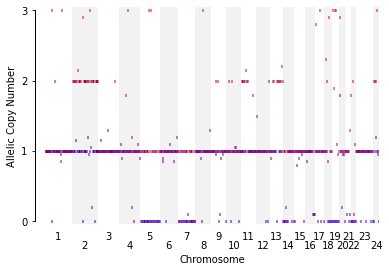

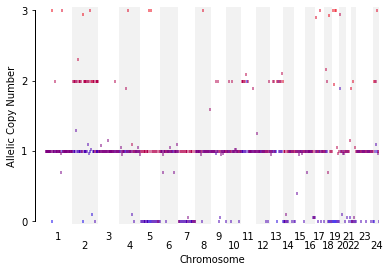

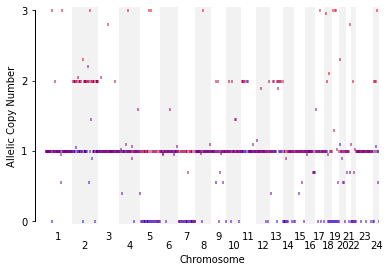

In [9]:
for t in timepoints:

    fig, ax = plt.subplots(1,1)
    fig = visualize.plot_cnv_profile.plot_acr_static(cnv_profiles_dict[t].cnv_profile_df, 
                                                     ax, cnv_profile.csize, 
                                                     segment_colors='difference', 
                                                     sigmas=False, 
                                                     min_seg_lw=3, 
                                                     y_upper_lim=3)


## Get target intervals and fasta file

In [10]:
target_intervals_df = pd.read_csv(target_interval_file,sep='\t', comment='@', 
                                 names=['chrom', 'start', 'stop', 'plus','target_name'])

/var/folders/xv/p7b1pgh104v0zb45t8klfywm0000gq/T/ipykernel_51199/478120738.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  target_intervals_df = pd.read_csv(target_interval_file,sep='\t', comment='@',


In [11]:
target_intervals_df = target_intervals_df[(target_intervals_df.chrom!='MT') & 
                                          (target_intervals_df.chrom!='Y') & 
                                          (target_intervals_df.chrom!='GL000228.1')]
target_intervals_df = target_intervals_df.rename(columns={'stop':'end'})
target_intervals_df['chrom'] = target_intervals_df['chrom'].apply(lambda x: '23' if x=='X' else str(x))

In [12]:
target_intervals_df['interval_length']=target_intervals_df['end']-target_intervals_df['start']
total_intervals_length = target_intervals_df['interval_length'].sum()
target_intervals_df['interval_weight'] = target_intervals_df['interval_length']/total_intervals_length

In [13]:
target_intervals_df['chrom'] = target_intervals_df['chrom'].astype(str)
target_intervals_df['start'] = target_intervals_df['start'].astype(int)
target_intervals_df['end'] = target_intervals_df['end'].astype(int)

## Generate coverage

In [14]:
# Only run once to generate, later need to load saved binned coverage instead

### generate ###

# sigma = 2
# x_coverage = 120

# binned_coverage_dict = {}

# for t in timepoints:
#     binned_coverage_df = target_intervals_df[['chrom','start','end']].copy()
#     dispersion_norm = np.random.normal(0, sigma, binned_coverage_df.shape[0])
#     binned_coverage = x_coverage * (binned_coverage_df['end'] - binned_coverage_df['start'])
#     this_chr_coverage = np.asarray([np.random.poisson(cov + np.exp(disp)) for cov, disp in
#                                    zip(binned_coverage, dispersion_norm)])
#     binned_coverage_df['cov'] = this_chr_coverage
#     binned_coverage_df.to_csv(f'{output_folder}/binned_coverage.{str(t)}.tsv', sep='\t', index=False, header=False)
#     binned_coverage_dict[t] = binned_coverage_df

################

##### load #####

binned_coverage_dict = {}

for t in timepoints:
    binned_coverage_dict[t] = pd.read_csv(f'{output_folder}/binned_coverage.{str(t)}.tsv', sep='\t', header=None, names=['chrom','start','end','cov'] )

################

In [15]:
corrected_binned_coverage_dict = {}

for t in timepoints:
    corrected_binned_coverage_df = cnv_profiles_dict[t].generate_coverage(purity_dict[t], f'{output_folder}/binned_coverage.{str(t)}.tsv')
    corrected_binned_coverage_df['chrom'] = corrected_binned_coverage_df['chrom'].astype(str)
    corrected_binned_coverage_df['start'] = corrected_binned_coverage_df['start'].astype(int)
    corrected_binned_coverage_df['end'] = corrected_binned_coverage_df['end'].astype(int)
    
    corrected_binned_coverage_dict[t] = corrected_binned_coverage_df.copy()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Combine corrected coverage with other interval metrics

In [16]:
interval_data_dict={}

for t in timepoints:
    interval_data_df = target_intervals_df.merge(corrected_binned_coverage_dict[t], on=['chrom', 'start', 'end'])
    interval_data_dict[t] = interval_data_df.copy()

## Generate SNVs

In [17]:
def get_alt_allele(ref_allele):
    possible_alleles = ['C', 'G', 'A', 'T']
    possible_alleles.remove(ref_allele)
    allele_index = random.choices(population=range(0,3), k=1)[0]
    
    return possible_alleles[allele_index]

def get_chrom_pos(interval, interval_data_df, fasta_file_path):
    interval_row = interval_data_df[interval_data_df.target_name==interval].iloc[0]
    
    #chrom = target_intervals_df.loc[interval,'chrom']
    #start = target_intervals_df.loc[interval,'start']
    #stop = target_intervals_df.loc[interval,'stop']
    
    chrom = interval_row['chrom']
    
    if chrom == '23':
        chrom = 'X'
    
    start = interval_row['start']
    end = interval_row['end']
    pos = random.choices(population=range(start,end), k=1)[0]

    ref_base_str = pysam.faidx(fasta_file_path, str(chrom)+':'+str(pos)+'-'+str(pos))
    ref_base = ref_base_str[-2]
    alt_base = get_alt_allele(ref_base)
    
    if chrom == 'X':
        chrom = '23'
    
    
    
    return chrom, pos, ref_base, alt_base



In [18]:
# Only run once to generate SNVs, later need to load saved SNVs instead

### generate ###

# num_variants = 100
# variants_df = pd.DataFrame(index=range(num_variants))

# variants_df['interval'] = random.choices(population=target_intervals_df.target_name, weights=target_intervals_df.interval_weight, k=num_variants)
# variants_df[['chrom','pos', 'ref_allele', 'alt_allele']] = variants_df.apply(lambda x: get_chrom_pos(x.interval, interval_data_df, fasta_file_path), axis=1, result_type='expand')
# variants_df['cluster'] = variants_df.apply(lambda x: random.choices(range(cnv_profiles_dict[timepoints[0]].phylogeny.num_subclones))[0]+1, axis=1)
# variants_df['allele'] = variants_df.apply(lambda x: 'maternal' if random.choices(range(2))[0]==0 else 'paternal', axis=1)

# variants_df.to_csv(f'{output_folder}/variants.tsv', sep='\t', index=False)

################

##### load #####

variants_df = pd.read_csv(f'{output_folder}/variants.tsv', sep='\t')

################

In [19]:
variants_df

,interval,chrom,pos,ref_allele,alt_allele,cluster,allele
0,chr9_32630096_32635577,9,32633172,G,T,4,maternal
1,chr11_66605837_66605916,11,66605905,A,T,5,maternal
2,chr1_39750968_39751062,1,39751000,A,G,5,paternal
3,chr12_50188547_50191177,12,50188980,A,G,1,paternal
4,chr19_14551954_14552255,19,14552174,T,C,2,paternal
...,...,...,...,...,...,...,...
95,chr10_70450564_70451571,10,70450644,T,C,5,paternal
96,chr5_35759669_35759821,5,35759719,A,T,5,paternal
97,chr2_211513196_211513264,2,211513223,T,A,6,paternal
98,chr10_32560481_32560845,10,32560541,A,T,4,maternal


## Add local ploidy, coverage, overlapping copy number events, multiplicity trees, vafs, and alt/ref counts to variants dataframes


Now that every mutation is assigned a cluster, we know what its cancer cell fraction is.  Given CCF, coverage, purity, and ploidy, we need to determine the variant allele fraction.

The vaf is determined by calculating the average number of copies of the mutation in all of the clusters, and adding up their contributions scaled by the CCF.  This value is scaled by the purity to obtain the average number of copies of the mutation per cell for the entire sample.  When divided by the local ploidy, this gives the variant allele fraction.

Given the true variant allele fraction, the alt and ref counts are determined by drawing from a binomial distribution with a mean of the vaf and a variance inversely proportional to the coverage.

In [20]:
def get_cov_and_ploidy(interval, interval_data_df):
    interval_row = interval_data_df[interval_data_df.target_name==interval].iloc[0]
    
    start = interval_row['start']
    end = interval_row['end']
    avg_covcorr = round(interval_row['covcorr']/(end-start))
    ploidy = interval_row['ploidy']
    
    return int(avg_covcorr), ploidy

def get_overlapping_events(mut, cnv_profile):
    chrom = str(mut.chrom)
    # if chrom=='X':
    #     chrom='23'
    
    if mut.allele=='paternal':
        events = cnv_profile.event_trees[chrom].paternal_tree.at(mut.pos)
        alt_allele_events = cnv_profile.event_trees[chrom].maternal_tree.at(mut.pos)
    elif mut.allele=='maternal':
        events = cnv_profile.event_trees[chrom].maternal_tree.at(mut.pos)
        alt_allele_events = cnv_profile.event_trees[chrom].paternal_tree.at(mut.pos)
    return events, alt_allele_events

def get_mut_and_unmut_copies_in_clone(upstream_mut, upstream_unmut, events, mut, clone):
    cn_change = 0
    is_possible = True
    
    unmut_copies = upstream_unmut
    mut_copies = upstream_mut
    
    for event in events:
        if (event.data.type!= 'haploid') & (event.data.cluster_num==clone):
            cn_change += event.data.cn_change
            
    if cn_change + upstream_mut + upstream_unmut < 0:
        raise Exception("Invalid CNAs!")
    
    # when examining a clone that the mutation doesn't occur in
    if mut.cluster!=clone: 
        
        # if copy gain, amplify mutated allele if one exists
        if cn_change > 0:
            if  mut_copies>0:
                mut_copies = upstream_mut + cn_change
            else:
                unmut_copies = upstream_unmut + cn_change 
            
        # if copy loss, delete unmutated allele if one exists
        elif cn_change < 0:
            if unmut_copies>0:
                unmut_copies = upstream_unmut + cn_change
            else:
                mut_copies = upstream_mut + cn_change
            
    # when examining the clone where the mutation occurs
    else:
        if upstream_mut !=0:
            print("Warning: Possibly overlapping mutations: already mutated copies at mutation event!")
            print(f'clone: {clone}')
        if (cn_change < 0) &  (upstream_unmut + cn_change <= 0) :
            print("No copies of allele left to mutate!")
            is_possible = False
        else:
            
            # if overlapping CN amplification event in same clone
            if cn_change > 0:
                mut_copies += 1+cn_change
                unmut_copies += -1
                
            # if overlapping CN deletion event in same clone...should I even allow this?
            elif cn_change < 0:
                mut_copies += 1
                unmut_copies += -1 + cn_change
                
            # if no overlapping CN event in same clone
            elif cn_change == 0:
                mut_copies += 1
                unmut_copies -= 1
        
    if mut_copies < 0:
        print("Can't have a negative number of mutated alleles!")
        is_possible = False
    if unmut_copies < 0:
        print("Can't have a negative number of unmutated alleles!")
        is_possible = False
    return mut_copies, unmut_copies, is_possible

def get_mut_multiplicity(mut, phylogeny):
    
    # mut is a series with: interval, chrom, pos, avg_covcorr, ploidy, ref_allele, cluster, allele, overlapping_CN_events
    print(f'chrom: {mut.chrom}, pos: {mut.pos}, cluster: {mut.cluster}, allele: {mut.allele}')
    
    mut_multiplicity_dict = {}
    
    for node in phylogeny.ccfs.keys():
        if node == 1:
            unmut_copies = 1
        else:
            unmut_copies = 0

        mut_multiplicity_dict[node]={'mut_copies':0, 'unmut_copies':unmut_copies}
    
    # iterate through nodes in the tree from top down 
    # such that every parent node is complete before any of it's children
    
    children = [1]
    nodes_calculated = []
    
    while children:
        new_children = []
        for child in children:
            
            if child!=1:
                parent = phylogeny.parents[child]
                upstream_mut = mut_multiplicity_dict[parent]['mut_copies']
                upstream_unmut = mut_multiplicity_dict[parent]['unmut_copies']
            else:
                upstream_mut = 0
                upstream_unmut = 1 # assume normal cells have one copy of each allele
            
            mut_num, unmut_num, is_possible = get_mut_and_unmut_copies_in_clone(upstream_mut,
                                                                   upstream_unmut, 
                                                                   mut.overlapping_CN_events, 
                                                                   mut,
                                                                   child)
            if not is_possible:
                return None
            else:
                mut_multiplicity_dict[child]['mut_copies'] = mut_num
                mut_multiplicity_dict[child]['unmut_copies'] = unmut_num
            
            new_children = new_children + phylogeny.get_children(child)
            nodes_calculated.append(child)
        children = new_children
    
    return mut_multiplicity_dict

def get_true_vaf(mut, phylogeny, purity):
    if mut.multiplicity is not None:
        total_mut_copies = 0
        for node in mut.multiplicity:
            node_fraction = phylogeny.ccfs[node]
            for child in phylogeny.get_children(node):
                node_fraction -= phylogeny.ccfs[child]
            total_mut_copies += node_fraction*mut.multiplicity[node]['mut_copies']*purity
        vaf = total_mut_copies/mut.ploidy
        if vaf > 1:
            raise Exception("More mutated copies than local ploidy!")
        return vaf
    else:
        return None
    
def get_alt_count(mut):
    if not math.isnan(mut.vaf):
        t_alt_count = round(s.binom.rvs(int(mut.avg_covcorr), mut.vaf, size=1)[0])
        return int(t_alt_count)
    
def get_local_allelic_cn(mut, ccfs, purity):
    a1 = 0
    a2 = 0
    
    for i in mut.overlapping_CN_events:
        a1 += i.data.cn_change*ccfs[i.data.cluster_num]
    for i in mut.alt_overlapping_CN_events:
        a2 += i.data.cn_change*ccfs[i.data.cluster_num]
    a1 = a1*purity+2*(1-purity)
    a2 = a2*purity+2*(1-purity)

    return a1, a2

In [21]:
variants_dict = {}
for t in timepoints:
    variants_df[['avg_covcorr', 'ploidy']] = variants_df.apply(lambda x: get_cov_and_ploidy(x.interval, interval_data_dict[t]), axis=1, result_type='expand')
    variants_df[['overlapping_CN_events','alt_overlapping_CN_events']] = variants_df.apply(lambda x: get_overlapping_events(x, cnv_profiles_dict[t]), axis=1, result_type='expand')
    variants_df['multiplicity'] = variants_df.apply(lambda x: get_mut_multiplicity(x, cnv_profiles_dict[t].phylogeny), axis=1)
    variants_df['vaf'] = variants_df.apply(lambda x: get_true_vaf(x, cnv_profiles_dict[t].phylogeny, purity_dict[t]), axis=1)
    variants_df['t_alt_count'] = variants_df.apply(lambda x: get_alt_count(x), axis=1)
    variants_df['t_ref_count'] = variants_df['avg_covcorr']-variants_df['t_alt_count']
    variants_df[['local_cn_a1','local_cn_a2']] = variants_df.apply(lambda x: get_local_allelic_cn(x, ccfs_dict[t], purity_dict[t]), axis=1, result_type='expand')
    variants_dict[t] = variants_df.copy()
    

chrom: 9, pos: 32633172, cluster: 4, allele: maternal
chrom: 11, pos: 66605905, cluster: 5, allele: maternal
chrom: 1, pos: 39751000, cluster: 5, allele: paternal
chrom: 12, pos: 50188980, cluster: 1, allele: paternal
chrom: 19, pos: 14552174, cluster: 2, allele: paternal
Can't have a negative number of unmutated alleles!
chrom: 3, pos: 113658765, cluster: 6, allele: maternal
chrom: 1, pos: 177133529, cluster: 2, allele: paternal
chrom: 14, pos: 23549466, cluster: 2, allele: maternal
chrom: 22, pos: 37964238, cluster: 5, allele: maternal
Can't have a negative number of unmutated alleles!
chrom: 20, pos: 47888128, cluster: 6, allele: paternal
chrom: 1, pos: 111663138, cluster: 6, allele: paternal
chrom: 19, pos: 44981591, cluster: 6, allele: maternal
chrom: 16, pos: 70564798, cluster: 3, allele: maternal
chrom: 6, pos: 135748437, cluster: 6, allele: maternal
chrom: 21, pos: 31802729, cluster: 2, allele: paternal
chrom: 16, pos: 55899915, cluster: 2, allele: paternal
chrom: 19, pos: 1394

## Save maf files

In [22]:
maf_file_dict={}

for t in timepoints:
    variants_dict[t]['Hugo_Symbol']='Unknown'
    variants_dict[t] = variants_dict[t].rename(columns={'chrom': 'Chromosome', 
                                                        'pos':'Start_position', 
                                                        'ref_allele':'Reference_Allele', 
                                                        'alt_allele':'Tumor_Seq_Allele2'})
    variants_dict[t] = variants_dict[t][['Hugo_Symbol', 
                                         'Chromosome',
                                         'Start_position',
                                         'Reference_Allele',
                                         'Tumor_Seq_Allele2',
                                         't_alt_count',
                                         't_ref_count',
                                         'local_cn_a1',
                                         'local_cn_a2',
                                         'cluster',
                                         'allele',
                                         'avg_covcorr',
                                         'ploidy',
                                         'overlapping_CN_events',
                                         'alt_overlapping_CN_events',
                                         'multiplicity',
                                         'vaf'
                                        ]]
    fn = f'simulated_maf.{t}.maf'
    variants_dict[t][(~variants_dict['t1'].vaf.isna())].to_csv(f'{output_folder}/{fn}', index=False, sep='\t')
    maf_file_dict[t] = fn

## Run PhylogicNDT

In [23]:
# make PhylogicNDT sif file

sampleIDs = list(sample_id_dict.values())
sample_mafs = list(maf_file_dict.values())
sample_cn_profiles = [''] * len(timepoints)
purities = map(str, list(purity_dict.values()))
times = map(str, list(timepoints_dict.values()))

with open(f'{output_folder}/{patient_id}.sif', 'w') as f:
    f.write('sample_id\tmaf_fn\tseg_fn\tpurity\ttimepoint')
    for line in sorted(zip(sampleIDs, sample_mafs, sample_cn_profiles, purities, times), key=lambda k: (float(k[4]), k[0])):
        f.write('\n'+'\t'.join(line))


In [24]:
# run the following commands in terminal where PhylogicNDT is installed from the same working directory used here
# python2 /phylogicndt/PhylogicNDT.py Cluster -i "patient1" -sif "patient1.sif" --maf_input_type "calc_ccf" -rb
